In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
print(tf.__version__)

2.0.0-rc1


In [2]:
import pandas as pd
pd.set_option('expand_frame_repr', False)
pd.set_option('display.width', 300)

In [3]:
def get_dataset():
    dataset = pd.read_csv("../data/prod_dataset.csv")
    return dataset

In [4]:
df = get_dataset()
wells = df.Well.unique()

In [5]:
wells

array(['BBE 13', 'BBR 11', 'BGL 11', 'BGL 13', 'BGL 14', 'PTR 12',
       'PTR 13', 'REY 13', 'REY 21', 'REY 22', 'REY 23', 'SPC 11',
       'SPC 12', 'YNG 11', 'YNG 12'], dtype=object)

In [6]:
al_methods = df.AL_Method.unique()
print(al_methods)

['INJECTION STRING' 'PLUNGER LIFT' nan 'PLUNGER LIFT / PUMPING UNIT'
 'PUMPING UNIT' 'INJECTION STRING - PRE/POST INSTALLATION' '1/4" SS'
 'ROD PUMP']


In [7]:
# Normalizing some AL Methods
# dataset.loc[dataset.AL_Method.isna(), ['AL_Method']] = 'NATURAL'
# dataset.loc[dataset.AL_Method == 'INJECTION STRING - PRE/POST INSTALLATION', ['AL_Method']] = 'INJECTION STRING'
# dataset.loc[dataset.AL_Method == 'PLUNGER LIFT / PUMPING UNIT', ['AL_Method']] = 'PLUNGER LIFT'

In [8]:
plot_wells = ['BGL 14', 'PTR 13', 'REY 22', 'SPC 11']

In [9]:
df.shape

(89085, 6)

In [10]:
df.head()

,Well,DayNo,Gas_Mcf,Cond_bpd,Water_bpd,AL_Method
0,BBE 13,1,149.0,NaN,9.32,INJECTION STRING
1,BBE 13,2,87.0,1.16,5.82,INJECTION STRING
2,BBE 13,3,109.0,NaN,2.33,INJECTION STRING
3,BBE 13,4,116.0,NaN,2.33,INJECTION STRING
4,BBE 13,5,111.0,1.16,4.65,INJECTION STRING


In [11]:
# for well in plot_wells:
#     data = df[df['Well'] == well].reset_index(drop=True)
#     x = np.sqrt(data.DayNo)
#     y = 1 / data.Gas_Mcf
    
# #     print(data.head())
    
#     plt.figure(figsize=(14, 6))
#     plt.plot(x, y, 'ro')
#     plt.yscale('log')
#     # plt.xscale('log')
#     plt.ylabel(r'1 / Gas Rate $(\frac{MSCF}{d})$')
#     plt.xlabel(r'$\sqrt{time (d)}$')
#     plt.title(data.Well[0])
#     plt.show;

In [12]:
# # Code Solution from somebody (long pseudoname) from Coursera
# def rolling_window(_array, size):
#     return np.array([ _array[n : n + size] for n in range(len(_array) - size + 1) ])
    
# dataset_x, dataset_y = np.hsplit(
#     rolling_window(data_train, window_size + 1), [window_size]
# )

# model.fit(dataset_x, dataset_y, epochs = 100, verbose = 0,
#           batch_size = batch_size, shuffle = True
#          )

# dataset = rolling_window(series, window_size)

# forecast = model.predict(dataset)
# forecast = forecast[split_time - window_size + 1 : ].flatten()

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    return dataset

In [14]:
print(df.loc[df['Well'] == 'BGL 14', 'Gas_Mcf'].values[:10], 
      df.loc[df['Well'] == 'BGL 14', 'Gas_Mcf'].values[10:11])

[205. 227. 221. 215. 227. 210. 221. 211. 223.  95.] [237.]


In [15]:
series = df.loc[df['Well'] == 'BGL 14', 'Gas_Mcf'].values

In [16]:
train_split = 0.8
split_time = int(train_split * len(series))

time = np.arange(0, len(series))

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
window_size = 12
batch_size = 24
shuffle_buffer_size = 100

In [18]:
series[:window_size]

array([205., 227., 221., 215., 227., 210., 221., 211., 223.,  95., 237.,
       221.])

In [19]:
series[-window_size:]

array([70., 76., 90., 69., 89., 76., 85., 86., 81., 76., 76., 68.])

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [21]:
# for x, y in dataset:
#     print(x.numpy())
#     print(y.numpy())

## Fit/Train Model

In [22]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

In [23]:
model = tf.keras.models.Sequential([l0])

In [24]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))
# model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6, momentum=0.9))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(dataset, epochs=30, verbose=1);

Epoch 1/30
198/198 [==============================] - 1s 4ms/step - loss: 565.1135
Epoch 2/30
198/198 [==============================] - 1s 3ms/step - loss: 564.4681
Epoch 3/30
198/198 [==============================] - 1s 4ms/step - loss: 568.6540
Epoch 4/30
198/198 [==============================] - 1s 4ms/step - loss: 563.2358
Epoch 5/30
198/198 [==============================] - 1s 4ms/step - loss: 564.9212
Epoch 6/30
198/198 [==============================] - 1s 4ms/step - loss: 564.0006
Epoch 7/30
198/198 [==============================] - 1s 4ms/step - loss: 564.0867
Epoch 8/30
198/198 [==============================] - 1s 3ms/step - loss: 564.7152
Epoch 9/30
198/198 [==============================] - 1s 4ms/step - loss: 563.0109
Epoch 10/30
198/198 [==============================] - 1s 4ms/step - loss: 565.3124
Epoch 11/30
198/198 [==============================] - 1s 4ms/step - loss: 564.5310
Epoch 12/30
198/198 [==============================] - 1s 4ms/step - loss: 566.9587
E

In [28]:
print("Layer Weights and Bias: {}".format(l0.get_weights()))

Layer Weights and Bias: [array([[0.07968865],
       [0.00263826],
       [0.04919109],
       [0.03093861],
       [0.03823035],
       [0.00993685],
       [0.01247131],
       [0.04665623],
       [0.07890003],
       [0.06459131],
       [0.07547988],
       [0.5026378 ]], dtype=float32), array([0.01697871], dtype=float32)]


In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Forecasting

In [30]:
forecast = []
split_time = int(len(series) * .8)

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

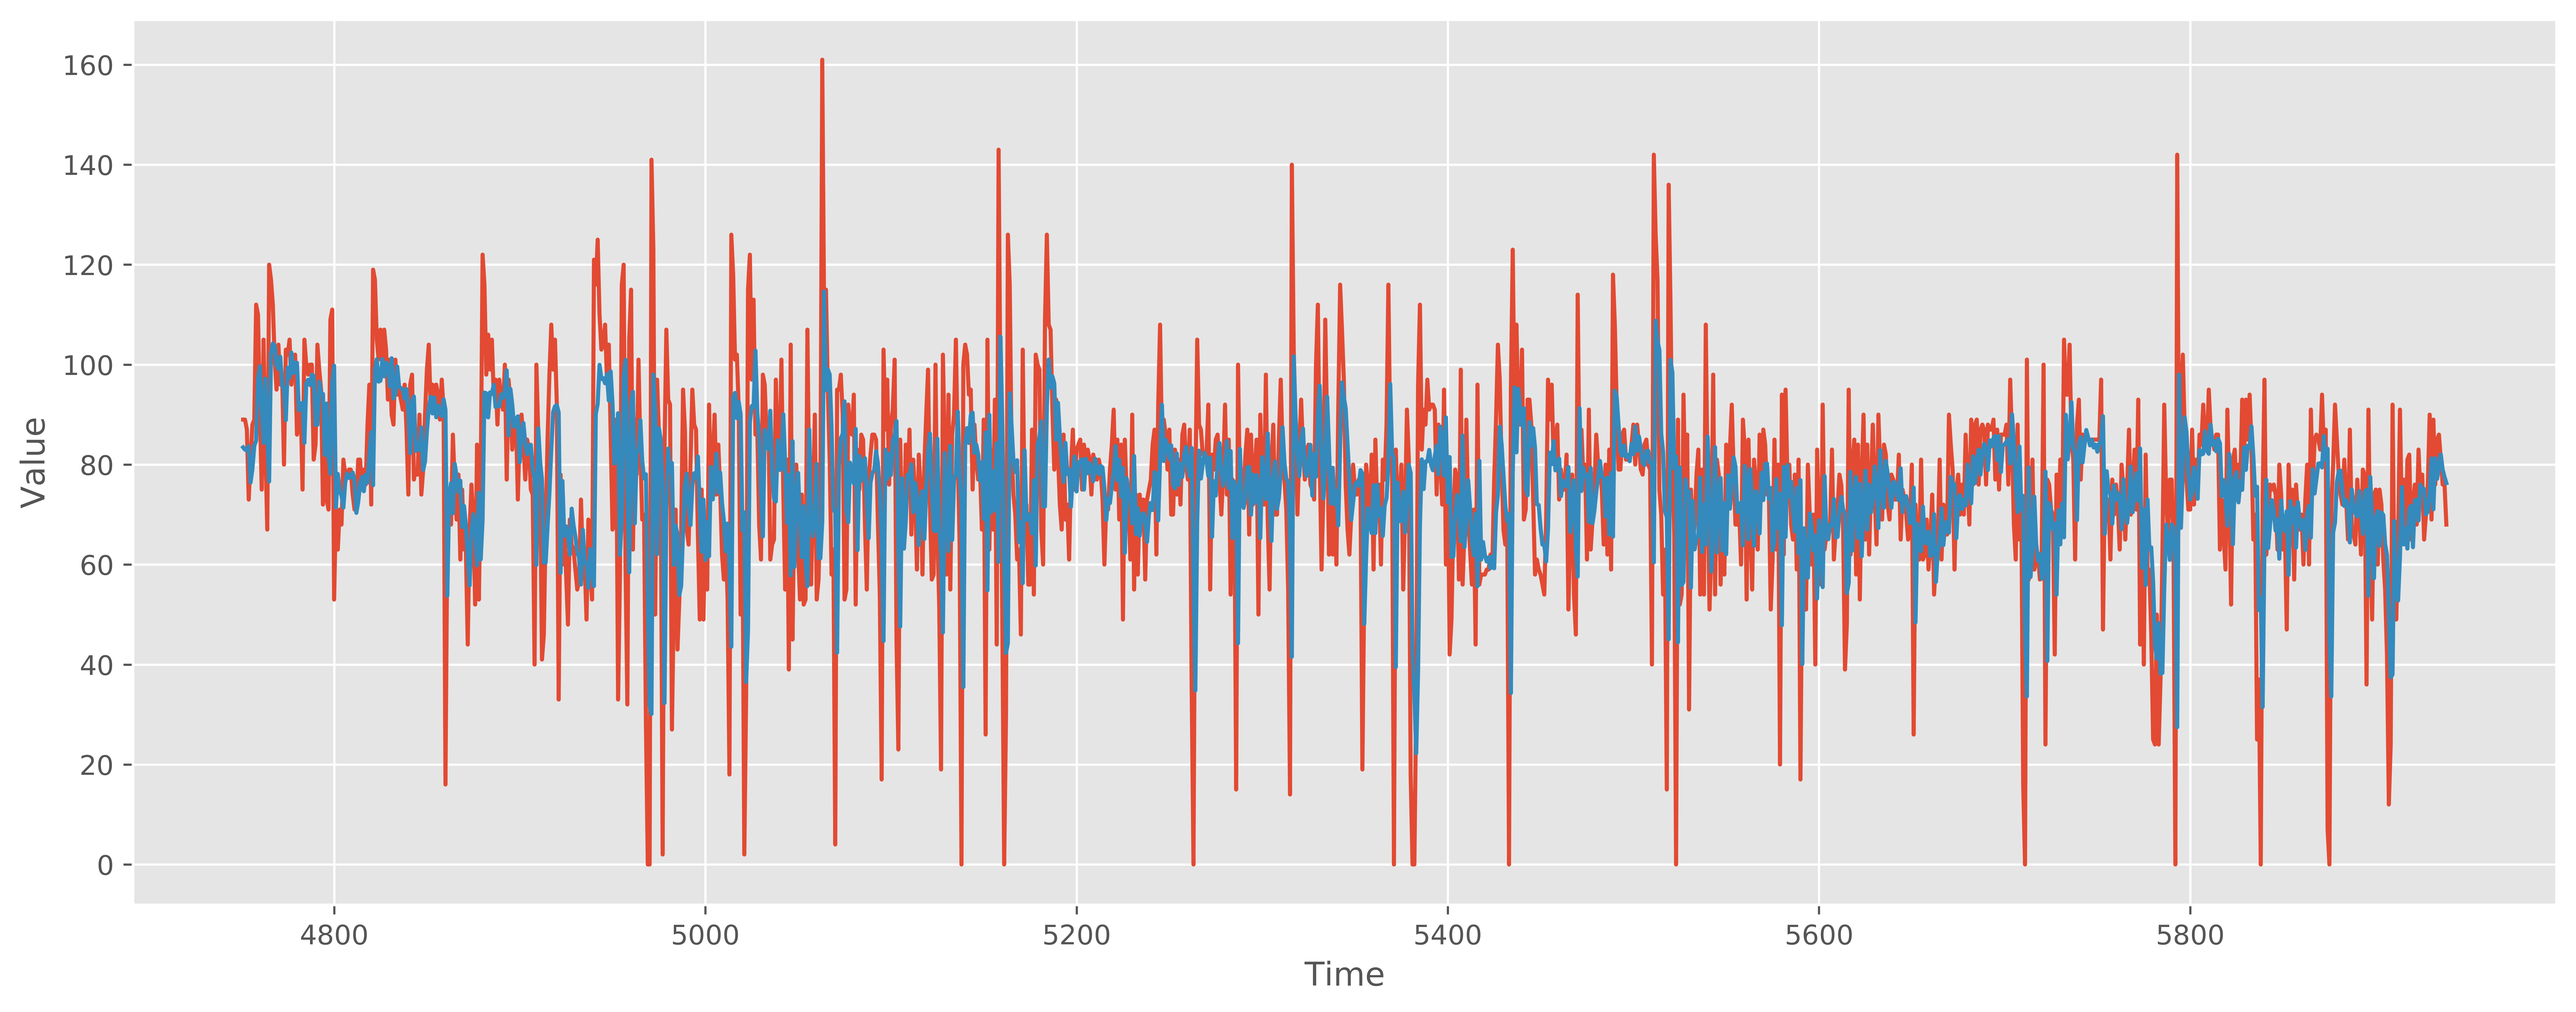

In [31]:
plt.figure(figsize=(16,6), dpi=800)

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.49777

## Prediction

In [33]:
print(series[:12], series[12:13])
print(model.predict(series[:12][np.newaxis]))

[205. 227. 221. 215. 227. 210. 221. 211. 223.  95. 237. 221.] [226.]
[[210.5433]]


In [34]:
print(series[12:24], series[24:25])
print(model.predict(series[12:24][np.newaxis]))

[226. 221. 223. 225. 226. 220. 226. 221. 227. 219. 226. 196.] [226.]
[[208.12746]]


In [35]:
print(series[5920:5932], series[5932:5933])
print(model.predict(series[5920:5932][np.newaxis]))

[72. 76. 68. 83. 74. 78. 65. 70. 76. 90. 69. 89.] [76.]
[[81.301155]]


In [ ]:
# for time in range(len(series) - window_size):
#     print(time, series[time:time + window_size], series[time + window_size:time + window_size + 1])